# Basic PyTorch model to classify images of playing cards

We will create an image classifier to detect playing cards.

We will divide this problem into 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

In [1]:
## Import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm # library designed for image classification

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
PyTorch version 2.0.0
Torchvision version 0.15.1
Numpy version 1.24.3
Pandas version 2.1.2


## Part 1: Pytorch Dataset/Dataloader

Setting up the dataset correctly is important:

- Organized way to structure how the data and labels are loaded into the model
- We can wrap the dataset in a dataloader and pytorch will handle batching the data shuffling while training the model

In [2]:
# Create a dataset by creating a class

class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)  # handle labeling based on folder names of the training data
    
    def __len__(self):  # dataloader needs to know how many samples will be included
        return len(self.data)
    
    def __getitem__(self, idx): # return one item based on the index
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # 

### Create train dataset

In [3]:
dataset = PlayingCardDataset(
    data_dir = '/kaggle/input/cards-image-datasetclassification/train')

In [4]:
len(dataset) # 7624 images

7624

41


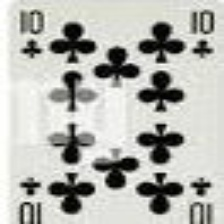

In [5]:
image, label = dataset[6000]
print(label)
image

In [6]:
# Get a dictionary associating labels (numeric values) to folder names
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

'/kaggle/input/cards-image-datasetclassification/train'

In [8]:
# Ensure image inputs are of same size
transform = transforms.Compose([transforms.Resize((128,128)), # image are 128x128
                               transforms.ToTensor(), # convert to Pytorch tensor
                               ])
# Transform dataset
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [9]:
image, label = dataset[100]
image.shape # 3 = number of channels

torch.Size([3, 128, 128])

In [12]:
# iterate over dataset
for image, label in dataset:
    break

### Dataloaders

Wrap the dataset in a Pytorch Dataloader object
- Handle dataset batching 
- Faster to train the model in batches instead of one at a time

In [13]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # shuffle = True when training, not necessary when testing

In [14]:
# iterate over the images
for images, labels in dataloader:
    break

In [15]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [16]:
labels

tensor([ 5, 49, 45, 44, 44, 41,  6, 22, 11, 51, 13,  3, 41, 51, 17, 47, 17,  9,
         0, 32, 15, 24, 10, 39,  8,  0,  1, 47, 19, 34, 34,  5])

## Part 2: Pytorch Model

Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.

- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.

In [28]:
# Create model
class SimpleCardClassifier(nn.Module):  # Pytorch's neural network module
    def __init__(self, num_classes=53): # 53 targets
        super(SimpleCardClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [29]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [30]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

## Part 3: The training loop

- Split data into train and test sets

- Terms:
  + Epoch: A run through entire dataset
  + Step: One batch of data as defined in dataloader <br>
  
- The loop: Load data to model in batches - calculate loss - perform backpropagation
 
- Parameters: 
   + Optimizer: ``adam`` is best place to start for most tasks
   + Loss function: What the model will optimize for

In [31]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # set learning rate

In [22]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


### Setup Datasets

In [33]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

train_folder = '/kaggle/input/cards-image-datasetclassification/train'
valid_folder = '/kaggle/input/cards-image-datasetclassification/valid'
test_folder =  '/kaggle/input/cards-image-datasetclassification/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Simple Training Loop

In [34]:
num_epochs=5
train_loss, val_loss = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Set the model to train
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

NameError: name 'inputs' is not defined

### Visualize Losses
